In [47]:
import pandas as pd

df = pd.read_csv("../../dataset/churn_data.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [48]:
df.drop('customerID', axis=1, inplace=True)


In [49]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)



/tmp/ipykernel_1004/3870995896.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [50]:
def profile_columns(df):
    profile = pd.DataFrame({
        
        'Data Type': df.dtypes,
        'Null Count': df.isnull().sum(),
        'Unique Values': df.nunique(),
        'Example Value': df.apply(lambda x: x.dropna().unique()[0] if x.dropna().size > 0 else None),
        'Sample Values': df.apply(lambda x: x.dropna().unique()[:5])
    })

    return profile.sort_values(by='Unique Values', ascending=False)

profile = profile_columns(df)
pd.set_option('display.max_rows', None)  
display(profile)

,Data Type,Null Count,Unique Values,Example Value,Sample Values
TotalCharges,float64,0,6531,29.85,"[29.85, 1889.5, 108.15, 1840.75, 151.65]"
MonthlyCharges,float64,0,1585,29.85,"[29.85, 56.95, 53.85, 42.3, 70.7]"
tenure,int64,0,73,1,"[1, 34, 2, 45, 8]"
PaymentMethod,object,0,4,Electronic check,"[Electronic check, Mailed check, Bank transfer..."
StreamingMovies,object,0,3,No,"[No, Yes, No internet service]"
TechSupport,object,0,3,No,"[No, Yes, No internet service]"
OnlineBackup,object,0,3,Yes,"[Yes, No, No internet service]"
StreamingTV,object,0,3,No,"[No, Yes, No internet service]"
DeviceProtection,object,0,3,No,"[No, Yes, No internet service]"
MultipleLines,object,0,3,No phone service,"[No phone service, No, Yes]"


In [51]:
# Binary mappings
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})




In [52]:
# df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})



# df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})

# df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
# df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
# df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})

# # Handle 'No service' cases as 0
# df['MultipleLines'] = df['MultipleLines'].map({'Yes': 1, 'No': 0, 'No phone service': 0})
# df['InternetService'] = df['InternetService'].map({'DSL': 1, 'Fiber optic': 2, 'No': 0})
# df['OnlineSecurity'] = df['OnlineSecurity'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
# df['OnlineBackup'] = df['OnlineBackup'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
# df['DeviceProtection'] = df['DeviceProtection'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
# df['TechSupport'] = df['TechSupport'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
# df['StreamingTV'] = df['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
# df['StreamingMovies'] = df['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})

# # Ordinal mapping for Contract
# df['Contract'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

# # Nominal mapping for PaymentMethod – use Label Encoding or Manual Mapping
# df['PaymentMethod'] = df['PaymentMethod'].map({
#     'Electronic check': 0,
#     'Mailed check': 1,
#     'Bank transfer (automatic)': 2,
#     'Credit card (automatic)': 3
# })



In [53]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

Categorical Columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [54]:
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

categorical_columns_encoded = df_encoded.select_dtypes(include=['uint8']).columns.tolist()
numerical_columns_encoded = df_encoded.select_dtypes(exclude=['uint8']).columns.tolist()

print("Encoded Categorical Columns:", categorical_columns_encoded)
print("Encoded Numerical Columns:", numerical_columns_encoded)




Encoded Categorical Columns: []
Encoded Numerical Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


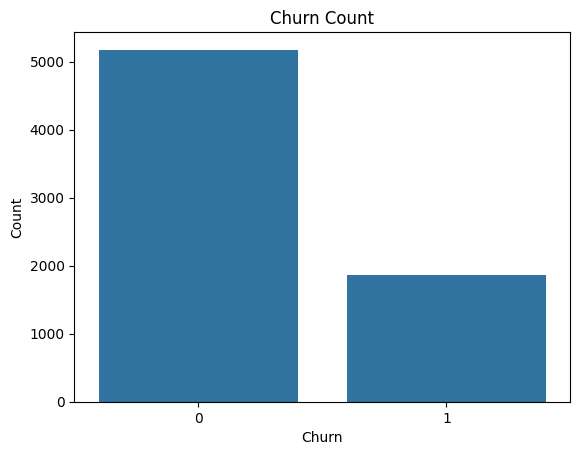

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


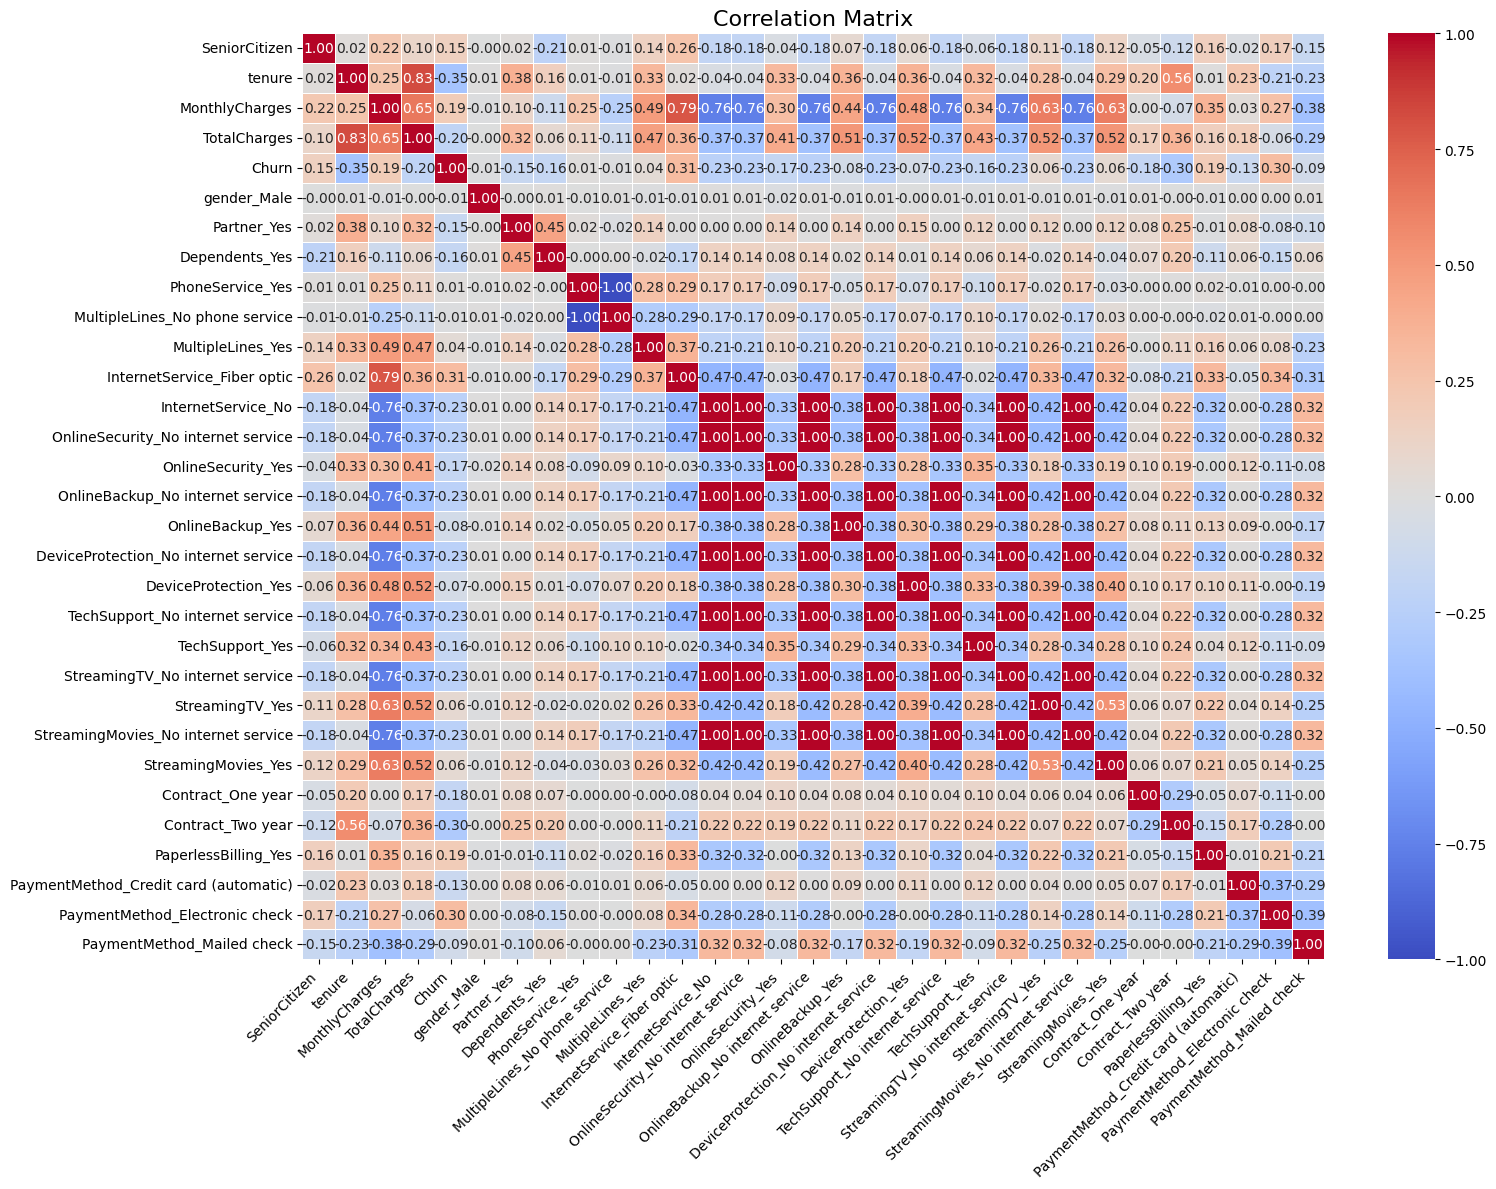

In [55]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Churn',data=df)
plt.title("Churn Count")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

print(df_encoded.columns.tolist())

plt.figure(figsize=(16, 12))  # Adjust width and height as needed
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [56]:
print(df_encoded.head())

   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0        False   
1              0      34           56.95       1889.50      0         True   
2              0       2           53.85        108.15      1         True   
3              0      45           42.30       1840.75      0         True   
4              0       2           70.70        151.65      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3        False           False             False   
4        False           False              True   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                            True  ...                            False   
1                           False  ...                            Fa

In [57]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [58]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict
y_pred = xgb_clf.predict(X_test)


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:47:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7849538679914834
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



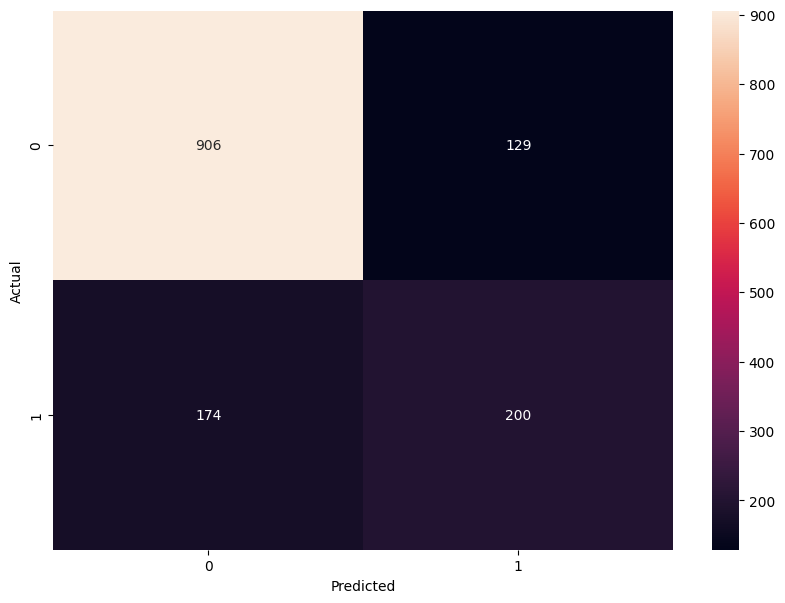

ROC AUC Score: 0.8214136247384329


In [59]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


y_proba = xgb_clf.predict_proba(X_test)[:,1]
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=3,                    
    scoring='roc_auc',       
    verbose=2,
    n_jobs=-1                 
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /w

[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /w

[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.8s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /w

[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.0s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.1s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.6s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.3s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.0s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.7s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.9s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.7s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.6s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   2.1s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.4s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.0s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.0s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.6s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.7s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.9s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.9s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   2.7s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   2.1s[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.3s

[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   2.8s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   2.2s


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [64]:
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)


best_model = grid_search.best_estimator_




Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best ROC AUC Score: 0.8489249200847637


Tuned Model Accuracy: 0.7955997161107168
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1035
           1       0.68      0.43      0.53       374

    accuracy                           0.80      1409
   macro avg       0.75      0.68      0.70      1409
weighted avg       0.78      0.80      0.78      1409



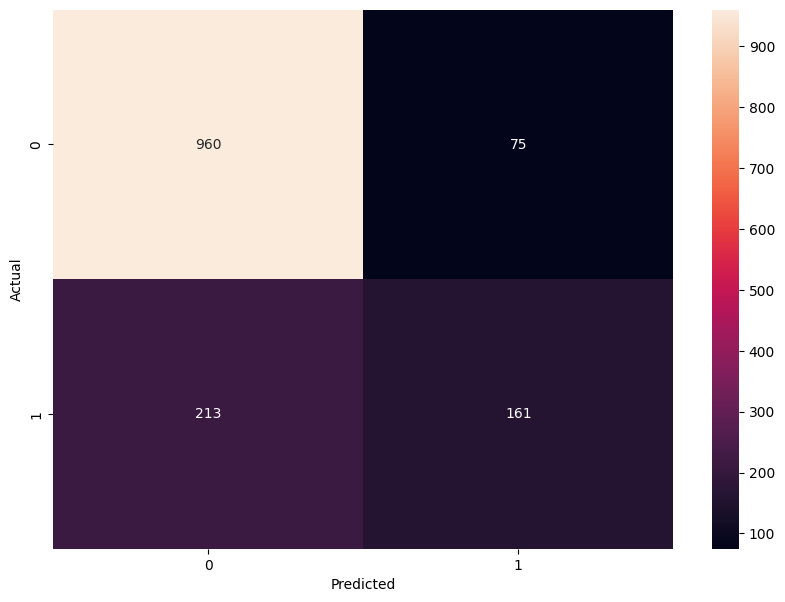

ROC AUC Score: 0.8455165465395644


In [ ]:

y_pred = best_model.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_proba = best_model.predict_proba(X_test)[:,1]
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))